## Loading dataset and liabraries

The dataset contains sentences as reviews by users of different platforms(eg. imdb, yeppy, etc). infront of every 
sentence label is mentioned as 0 and 1, negative or positive.

In [1]:
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
with open('sentiment_labelled_sentences/full_set.txt') as file:
    data=file.readlines()
    
data=[x.strip() for x in data]
sentences=[x.split('\t')[0] for x in data]
labels=[x.split('\t')[1] for x in data]

y=np.asanyarray(labels,'int')
y=2*y-1

## Processing data

In [3]:
digits=[x for x in string.digits]
punc=string.punctuation

def vanish(x,arr):
    for item in arr:
        if item in x:
            arr=arr.replace(item,'')
    return arr

digit_free=[vanish(digits,sentence) for sentence in sentences]
punc_free=[vanish(punc,sentence) for sentence in digit_free]
punc_free=[x.lower() for x in punc_free]

#### Stop words

In [4]:
stop_words=set(['a','an','the','i','they','we','them','us','you','from','at','for','there','here','to','it'
           ,'he','she','of','am','is','so','me','in','us'])
stripped=[x.split() for x in punc_free]
processed=[' '.join(list(filter(lambda a: a not in stop_words, x))) for x in stripped]

#### Bag of Words

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
CV=CountVectorizer(analyzer='word',max_features=4500)
data=CV.fit_transform(processed)

#### Adding Bias term 

'1' is added to the end of feature set to set the default value of the prediction. In case of linear regression 
it is used to track the base case(i.e. output is 0), gives the default value to set the model more effectively.
In case of logistic regression it is the outcome when all the predictors are zero,i.e. the INTERCEPT. The coefficient of this bias term is equal to the intercept of the fitted model.

In [6]:
data=data.toarray()
data=np.append(data,np.ones(len(data),int).reshape(-1,1),axis=1)

## Splitting data train and test set

In [7]:
n=500

test_indices=np.append(np.random.choice(np.where(y==1)[0],int(n/2),replace=0),\
          (np.random.choice(np.where(y==-1)[0],int(n/2),replace=0)),axis=0)
train_indices=list(set(range(len(y)))-set(test_indices))

x_test=data[test_indices,]
y_test=y[test_indices,]
x_train=data[train_indices,]
y_train=y[train_indices,]

## Fitting logistic regression 

Here we use stochaistic gradient descent technique instead of logistic regression which uses gradient descent for
optimization, due to large set of features(i.e. 4500) which may take computationally longer time in case of actual gradient descent.

In [10]:
from sklearn.linear_model import SGDClassifier
clf=SGDClassifier(loss='log',penalty=None)
clf.fit(x_train,y_train)

a=clf.coef_
b=clf.intercept_

y_hat_trn=clf.predict(x_train)
y_hat_tst=clf.predict(x_test)

error_trn=np.sum(np.not_equal(y_hat_trn,y_train))/len(y_train)
error_tst=np.sum(np.not_equal(y_hat_tst,y_test))/len(y_test)

print('Training error: ',error_trn)
print('Test error: ',error_tst)

Training error:  0.0024
Test error:  0.232


#### Fraction of data vs Margin

In [11]:
def margin(gamma,data,clf):
    probab=clf.predict_proba(data)[:,1]
    margin_len=sum(((probab>(0.5+gamma)) | (probab<(0.5-gamma))))
    return margin_len/500

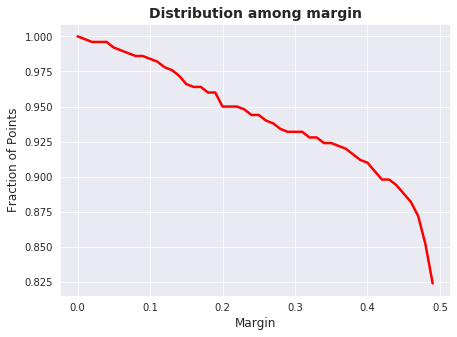

In [12]:
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['figure.figsize']=(7,5)
gamma=np.arange(0,0.5,0.01)
marg=[margin(i,x_test,clf) for i in gamma]
plt.plot(gamma,marg,'red',linewidth=2.5)
plt.title('Distribution among margin',fontsize=14,weight='bold')
plt.xlabel('Margin',fontsize=12)
plt.ylabel('Fraction of Points',fontsize=12)
plt.show()

#### Error vs Margin

In [13]:
def margin_error(gamma,probab):
    marg_ind=np.where((probab<(0.5-gamma))|(probab>(0.5+gamma)))[0]
    errors=np.not_equal(y_test[marg_ind],y_hat_tst[marg_ind])
    return sum(errors)/len(y_test)

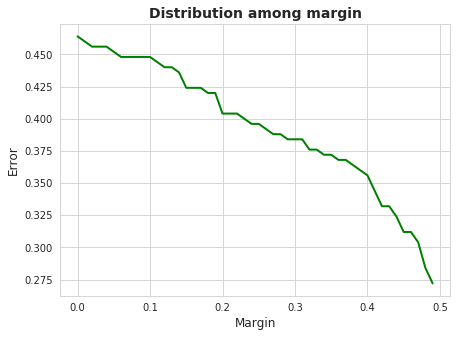

In [14]:
sns.set_style('whitegrid')
gamma=np.arange(0,0.5,0.01)
probab=clf.predict_proba(x_test)
errors=[margin_error(i,probab) for i in gamma]
plt.plot(gamma,errors,'green',linewidth=2)
plt.title('Distribution among margin',fontsize=14,weight='bold')
plt.xlabel('Margin',fontsize=12)
plt.ylabel('Error',fontsize=12)
plt.show()

### Words with larger influence

These are the features or words with larger coefficients

In [15]:
import operator
vocab=np.array([z[0] for z in sorted(CV.vocabulary_.items(),key=operator.itemgetter(1))])
sort_ind=np.argsort(a)[0]

print('Words with most Negative influence: \n',vocab[sort_ind[0:50]])
print('\nWords with most positive influence: \n',vocab[sort_ind[-49:-1]])

Words with most Negative influence: 
 ['worst' 'then' 'stupid' 'poor' 'disappointment' 'difficult' 'months'
 'fails' 'took' 'failed' 'chilly' 'bad' 'crap' 'slow' 'arent' 'horrible'
 'awful' 'buying' 'rude' 'chargers' 'lame' 'empty' 'avoid' 'wouldnt'
 'tasted' 'waste' 'tables' 'return' 'restaurants' 'too' 'rated' 'weak'
 'yum' 'lousy' 'nothing' 'unfortunately' 'part' 'zero' 'accidentally'
 'last' 'directing' 'dirt' 'above' 'valley' 'pay' 'picture' 'average'
 'plug' 'hours' 'overpriced']

Words with most positive influence: 
 ['rocks' 'masculine' 'screamy' 'comfortable' 'seller' 'shot' 'youre'
 'holds' 'say' 'reviews' 'day' 'actresses' 'liked' 'happier' 'dialing'
 'light' 'glad' 'interesting' 'job' 'carry' 'clear' 'tasty' 'song' 'wow'
 'lovely' 'paper' 'prices' 'sex' 'favorite' 'incredible' 'beautiful'
 'fantastic' 'greek' 'perfectly' 'played' 'nice' 'fun' 'wonderful'
 'perfect' 'great' 'amazing' 'awesome' 'works' 'plus' 'excellent' 'love'
 'delicious' 'loved']


### Abstain Classifier

Now, how about building an 'Abstain Classifier' in which the classifier is allowed to abstain in certain cases
but very infrequently. For this we must set a margin for the classifier so that it doesnt abstain frequently and
the error rate is also reduces to minimum.

In [21]:
class abstain:
    x=0
    y=0
    test=0
    
    def __init__(self,x,y,test):
        self.x_train=x
        self.y_train=y
        self.test=test
        
        model=SGDClassifier(loss='log',penalty='none')
        model.fit(self.x_train,self.y_train)
        self.probab=model.predict_proba(self.test)
        self.predict=model.predict(self.test)
    
    def prediction(self):
        y_hat=np.asanyarray(self.predict,float)
        
        for i in range(len(self.test)):
            margin=abs(self.probab[i,0]-0.5)
            if margin<0.4:
                y_hat[i]=np.nan          
        return y_hat

Error calculation and comparison

In [25]:
model=abstain(x=x_train,y=y_train,test=x_test)
y_hat=model.prediction()

nan=sum(np.isnan(y_hat))
error=sum(np.not_equal(model.predict,y_test))/len(y_test)
error_abs=(sum(np.not_equal(y_hat,y_test))-nan)/(len(y_test)-nan)

print('Fraction of data Abstained: ',nan/len(y_test))
print('Error calculation with abstain classification: ',error_abs)
print('Error calculation without abstain classification: ',error)

Fraction of data Abstained:  0.076
Error calculation with abstain classification:  0.18181818181818182
Error calculation without abstain classification:  0.218
